In [15]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

In [18]:
def compute_loss(model, x, omega):
    u = model(x)
    u.requires_grad_(True)
    u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    residual = torch.autograd.grad(u_x, x, grad_outputs=torch.cos(omega * x), create_graph=True)[0] - torch.cos(omega * x)
    loss_r = torch.mean(residual**2)
    loss_ic = (model(torch.tensor([0.0])))**2
    loss = loss_r + loss_ic
    return loss, loss_r, loss_ic

In [19]:
class PINN(nn.Module):
    def __init__(self, num_hidden_layers, num_neurons_per_layer):
        super(PINN, self).__init__()
        self.hidden = nn.ModuleList([nn.Linear(1, num_neurons_per_layer), nn.Tanh()] +
                                    [nn.Linear(num_neurons_per_layer, num_neurons_per_layer), nn.Tanh()] * (num_hidden_layers - 1))
        self.output_layer = nn.Linear(num_neurons_per_layer, 1)

    def forward(self, x):
        x.requires_grad_(True)
        for layer in self.hidden:
            x = layer(x)
        return self.output_layer(x)


In [33]:
def train(model, omega, num_points, num_epochs, num_hidden_layers, num_neurons_per_layer, learning_rate):
    x_train = torch.linspace(-2*np.pi, 2*np.pi, num_points).reshape(-1, 1).float()
    x_train.requires_grad_(True)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    for epoch in range(num_epochs):
        optimizer.zero_grad()
        loss, _, _ = compute_loss(model, x_train, omega)
        loss.backward()
        optimizer.step()

        if epoch % 10000 == 0:
            print(f'Epoch {epoch}/{num_epochs}, Total loss: {loss.item()}')

    return model

In [34]:
def plot_results(x, u_true, u_pred, title):
    plt.figure(figsize=(10, 5))
    plt.plot(x.detach().numpy(), u_true, label='True Solution')
    plt.plot(x.detach().numpy(), u_pred, label='Predicted Solution')
    plt.xlabel('x')
    plt.ylabel('u')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

In [35]:
num_hidden_layers = [2, 4, 5]
num_neurons_per_layer = [16, 64, 128]
num_points_train = [200, 3000]
num_points_test = [1000, 5000]
num_epochs = 50000
learning_rate = 0.001

Epoch 0/50000, Total loss: 0.5464540719985962
Epoch 10000/50000, Total loss: 0.0004535667540039867
Epoch 20000/50000, Total loss: 4.8675698053557426e-05
Epoch 30000/50000, Total loss: 1.43056022352539e-05
Epoch 40000/50000, Total loss: 0.00012229215644765645


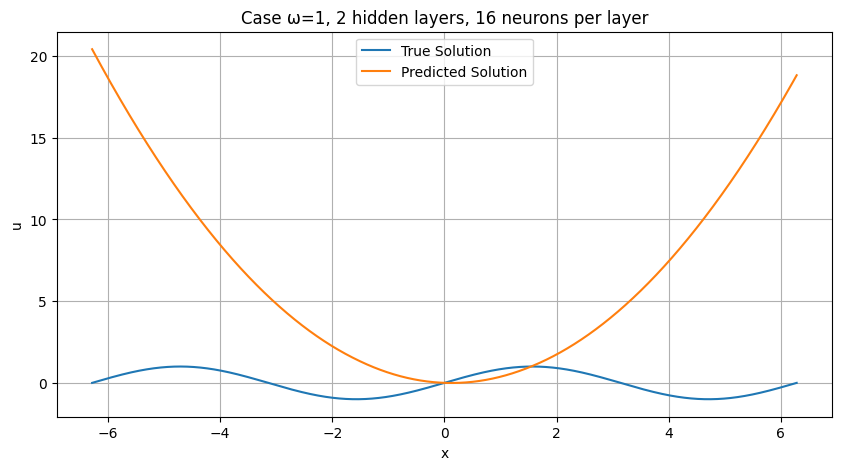

Epoch 0/50000, Total loss: 0.5670638084411621
Epoch 10000/50000, Total loss: 3.694860060932115e-05
Epoch 20000/50000, Total loss: 7.977180757734459e-06
Epoch 30000/50000, Total loss: 4.144568447372876e-05
Epoch 40000/50000, Total loss: 1.875951056717895e-06


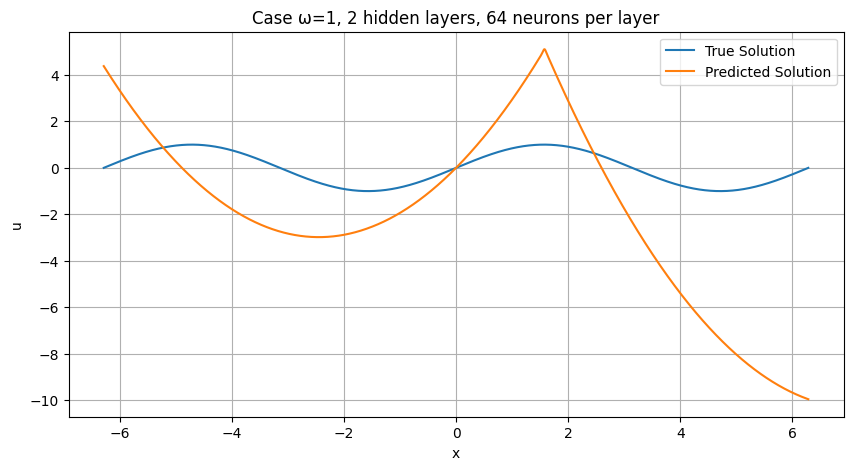

Epoch 0/50000, Total loss: 0.5167994499206543
Epoch 10000/50000, Total loss: 0.0006796895759180188
Epoch 20000/50000, Total loss: 2.7865042284247465e-05
Epoch 30000/50000, Total loss: 3.021182055817917e-05
Epoch 40000/50000, Total loss: 4.2395035961817484e-06


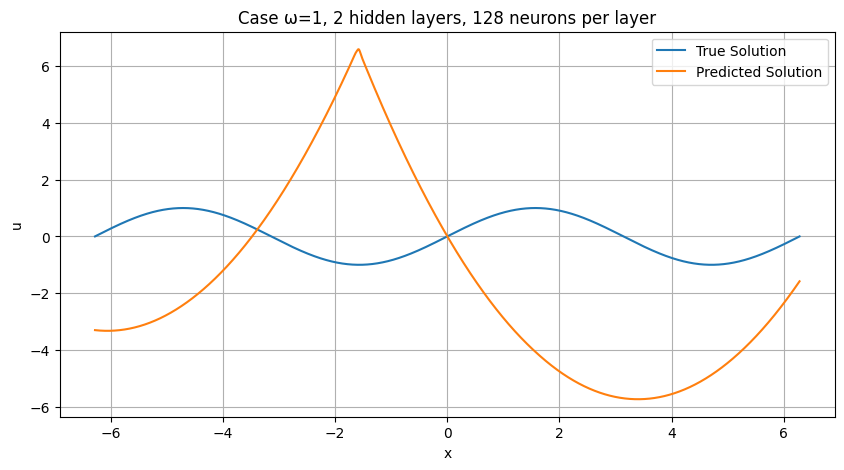

Epoch 0/50000, Total loss: 0.5647642612457275
Epoch 10000/50000, Total loss: 0.0009348064777441323
Epoch 20000/50000, Total loss: 2.722070894378703e-05
Epoch 30000/50000, Total loss: 7.311869558179751e-05
Epoch 40000/50000, Total loss: 1.3334285540622659e-05


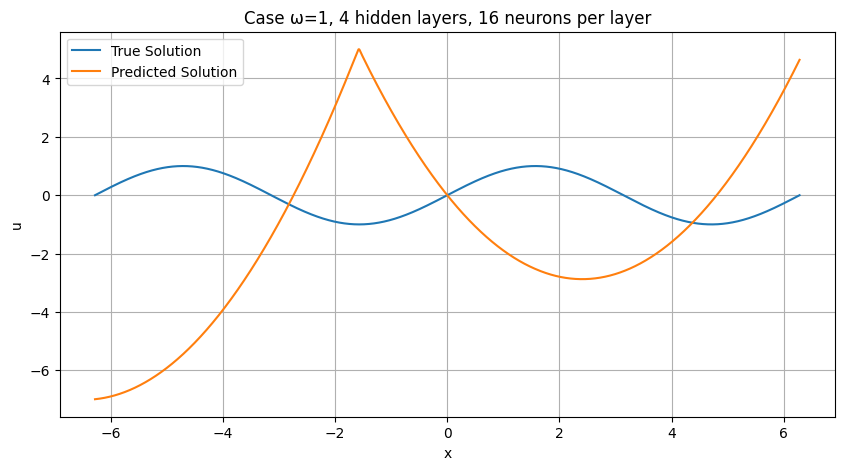

Epoch 0/50000, Total loss: 0.5484582185745239
Epoch 10000/50000, Total loss: 0.0061266375705599785
Epoch 20000/50000, Total loss: 8.092920324997976e-05
Epoch 30000/50000, Total loss: 9.000619320431724e-05
Epoch 40000/50000, Total loss: 5.781026629847474e-06


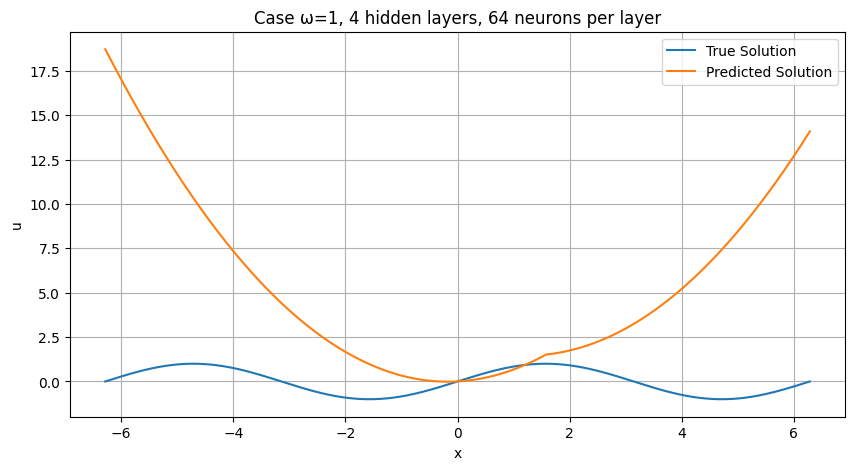

Epoch 0/50000, Total loss: 0.5146830677986145
Epoch 10000/50000, Total loss: 0.000145026104291901
Epoch 20000/50000, Total loss: 0.00046317209489643574
Epoch 30000/50000, Total loss: 0.0005865082493983209
Epoch 40000/50000, Total loss: 0.00010958097118418664


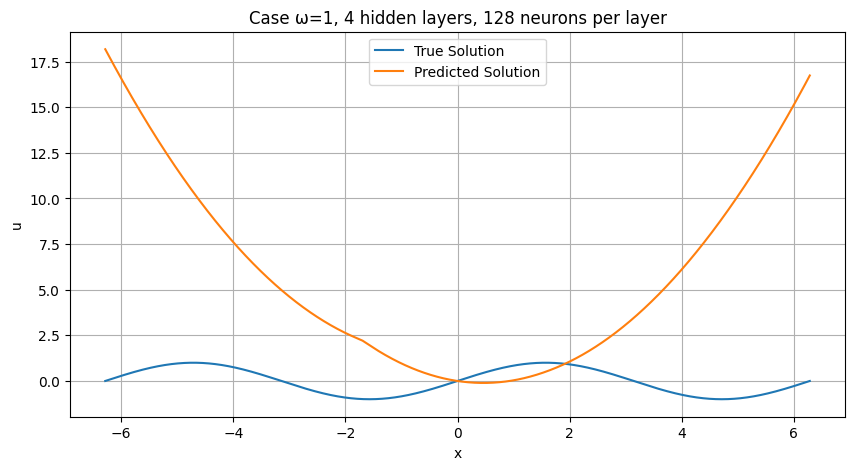

Epoch 0/50000, Total loss: 0.5317553877830505
Epoch 10000/50000, Total loss: 0.018796103075146675
Epoch 20000/50000, Total loss: 0.010798751376569271
Epoch 30000/50000, Total loss: 0.00039245301741175354
Epoch 40000/50000, Total loss: 6.0221453168196604e-05


KeyboardInterrupt: 

In [36]:
# Przypadek ω = 1
omega_1 = 1
for num_hidden in num_hidden_layers:
    for num_neurons in num_neurons_per_layer:
        model = PINN(num_hidden, num_neurons)
        trained_model = train(model, omega_1, num_points_train[0], num_epochs, num_hidden, num_neurons, learning_rate)
        x_test = torch.linspace(-2*np.pi, 2*np.pi, num_points_test[1]).reshape(-1, 1).float()
        u_true = (1/omega_1) * np.sin(omega_1 * x_test.detach().numpy())
        u_pred = trained_model(x_test).detach().numpy().flatten()
        plot_results(x_test, u_true, u_pred, f'Case ω=1, {num_hidden} hidden layers, {num_neurons} neurons per layer')

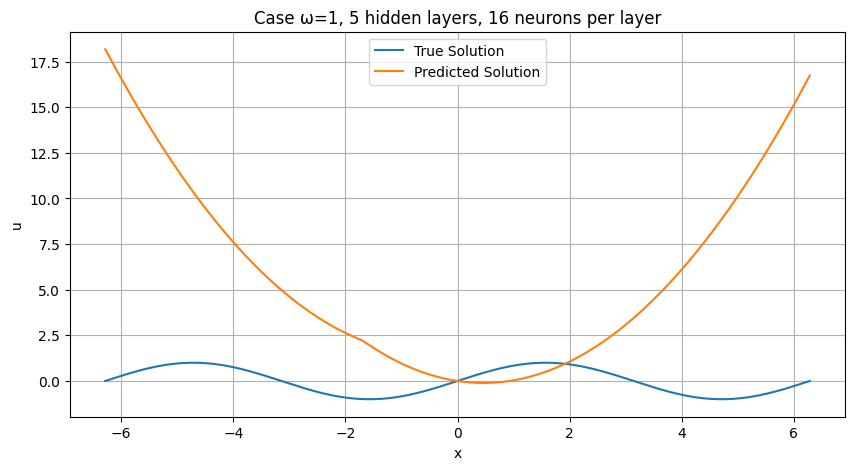

In [37]:
plot_results(x_test, u_true, u_pred, f'Case ω=1, {num_hidden} hidden layers, {num_neurons} neurons per layer')

In [ ]:
omega_15 = 15
for num_hidden in num_hidden_layers:
    for num_neurons in num_neurons_per_layer:
        model = PINN(num_hidden, num_neurons)
        trained_model = train(model, omega_15, num_points_train[1], num_epochs, num_hidden, num_neurons, learning_rate)
        x_test = torch.linspace(-2*np.pi, 2*np.pi, num_points_test[1]).reshape(-1, 1).float()
        u_true = (1/omega_15) * np.sin(omega_15 * x_test.numpy())
        u_pred = trained_model(x_test).detach().numpy().flatten()
        plot_results(x_test, u_true, u_pred, f'Case ω=15, {num_hidden} hidden layers, {num_neurons} neurons per layer')

In [ ]:
plot_results(x_test, u_true, u_pred, f'Case ω=15, {num_hidden} hidden layers, {num_neurons} neurons per layer')